<a href="https://colab.research.google.com/github/Ayowolet/Deploying-a-Sentiment-Analysis-Model-/blob/master/Text_Generation1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import RNN
from keras.utils import np_utils
import tensorflow as tf
import matplotlib.pyplot as pyplot
from sklearn.model_selection import train_test_split

In [4]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
text = (open("/content/gdrive/My Drive/NLP/affirm.txt").read())
text=text.lower()

In [15]:
characters = sorted(list(set(text)))

n_to_char = {n:char for n, char in enumerate(characters)}
char_to_n = {char:n for n, char in enumerate(characters)}

In [16]:
X = []
Y = []
length = len(text)
seq_length = 100

for i in range(0, length-seq_length, 1):
    sequence = text[i:i + seq_length]
    label =text[i + seq_length]
    X.append([char_to_idx[char] for char in sequence])
    Y.append(char_to_idx[label])

In [17]:
X_modified = np.reshape(X, (len(X), seq_length, 1))
X_modified = X_modified / float(len(characters))
Y_modified = np_utils.to_categorical(Y)

train_X, tst_X, train_Y, tst_Y = train_test_split(X_modified, Y_modified, test_size=0.6, shuffle=True)
X_test, X_valid, Y_test, Y_valid = train_test_split(tst_X, tst_Y, train_size=0.5, shuffle=True)


In [18]:
# Define a simple sequential model
def create_model():
  model = Sequential()
  '''
  model.add(tf.keras.layers.Bidirectional(LSTM(128, input_shape=(maxlen, len(vocabulary)), return_sequences=True)))
  model.add(Dropout(0.1))
  model.add(tf.keras.layers.Bidirectional(LSTM(256)))
  model.add(Dropout(0.1))
  model.add(tf.keras.layers.Dense(len(vocabulary), activation='softmax'))
  '''
  model.add(LSTM(256, input_shape = (train_X.shape[1], train_X.shape[2]), return_sequences=True))
  model.add(Dropout(0.1))
  model.add(LSTM(512))
  model.add(Dropout(0.1))
  model.add(Dense(train_Y.shape[1], activation='softmax'))

  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=10000, decay_rate=0.9)
  optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=[tf.metrics.CategoricalCrossentropy(), 'accuracy'])

  return model

# Create a basic model instance
model = create_model()

model.build(input_shape=((train_X.shape[1], train_X.shape[2]), 1))

# Display the model's architecture
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 100, 256)          264192    
_________________________________________________________________
dropout_4 (Dropout)          (None, 100, 256)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 512)               1574912   
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 65)                33345     
Total params: 1,872,449
Trainable params: 1,872,449
Non-trainable params: 0
_________________________________________________________________


In [10]:
checkpoint_path = "/content/gdrive/My Drive/NLP/Experiments/basic1/cp.ckpt"
#checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only = True,
                                                 verbose=1)

#print("Learning rate before first fit:", model.optimizer.learning_rate.numpy())

# Train the model with the new callback
history = model.fit(train_X, train_Y,  
          epochs=50,
          batch_size = 64,
          validation_data=(X_valid, Y_valid),
          callbacks=[cp_callback])  # Pass callback to training

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.

# Change learning rate to 0.001 and train for 25 more epochs


Epoch 1/50
1003/1003 [==============================] - 118s 109ms/step - loss: 3.0196 - categorical_crossentropy: 3.0196 - accuracy: 0.1806 - val_loss: 2.6898 - val_categorical_crossentropy: 2.6898 - val_accuracy: 0.2402

Epoch 00001: val_loss improved from inf to 2.68979, saving model to /content/gdrive/My Drive/NLP/Experiments/basic1/cp.ckpt
Epoch 2/50
1003/1003 [==============================] - 108s 108ms/step - loss: 2.6477 - categorical_crossentropy: 2.6477 - accuracy: 0.2506 - val_loss: 2.4347 - val_categorical_crossentropy: 2.4347 - val_accuracy: 0.3110

Epoch 00002: val_loss improved from 2.68979 to 2.43467, saving model to /content/gdrive/My Drive/NLP/Experiments/basic1/cp.ckpt
Epoch 3/50
1003/1003 [==============================] - 108s 108ms/step - loss: 2.3592 - categorical_crossentropy: 2.3592 - accuracy: 0.3273 - val_loss: 2.2374 - val_categorical_crossentropy: 2.2374 - val_accuracy: 0.3583

Epoch 00003: val_loss improved from 2.43467 to 2.23736, saving model to /conten

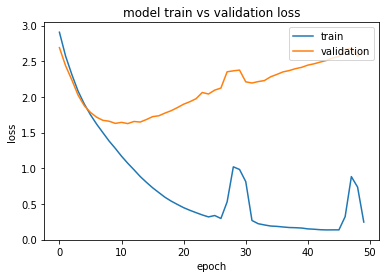

In [11]:
# plot train and validation loss
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [19]:
model = create_model()

checkpoint_dir = "/content/gdrive/My Drive/NLP/Experiments/basic1"

latest = tf.train.latest_checkpoint(checkpoint_dir)

model.load_weights(latest)

loss = model.evaluate(X_test, Y_test)
#print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

1504/1504 [==============================] - 15s 9ms/step - loss: 1.3078 - categorical_crossentropy: 1.3078 - accuracy: 0.6450


In [20]:

string_mapped = X[99]
full_string = [n_to_char[value] for value in string_mapped]
# generating characters
for i in range(400):
    x = np.reshape(string_mapped,(1,len(string_mapped), 1))
    x = x / float(len(vocabulary))

    pred_index = np.argmax(model.predict(x, verbose=0))
    seq = [n_to_char[value] for value in string_mapped]
    full_string.append(n_to_char[pred_index])

    string_mapped.append(pred_index)
    string_mapped = string_mapped[1:len(string_mapped)]
  

In [21]:

txt=""
for char in full_string:
    txt = txt+char
txt


"lled with the fullness of god, loaded with all power, glory, might, and grace of divinity! i am an abie io the fooseousress of god in christ  i have a goly spirit in ly spirit and fooouring woul god s poace in my spirit and fooouring woul god in my life. i am souerd and clrired to an eeie io all things in me. i m corn agaause the lord ias given me in the seglt of thises are sake that the sitea hald of condsion, i am a bhi-tiine in thi word. i am supergor to the soirit, i m ind'iisur christ. i am"